# Density-Based Spatial Clustering of Applications with Noise from Scratch
***
## Table of Contents
1. [Introduction](#1-introduction)
***

In [43]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## 1. Introduction
Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a density-based clustering algorithm (unsupervised learning method) that groups data points in high-density regions while identifying outliers in low-density areas. Unlike centroid-based methods like K-Means, it discovers arbitrarily shaped clusters without requiring pre-specified cluster counts.

### Key Concepts
- $\epsilon$: Radius that defines the neighbourhood of each point.
- $\text{MinPts}$: Minimum number of points required in the $\epsilon$-neighbourhood to form a cluster.
- DBSCAN algorithm identifies the following three types of points during the process:
    - **Core point**: A point that has at least $\text{MinPts}$ neighbours (including itself) within $\epsilon$.
    - **Border point**: A point within $\epsilon$ of a core point but has less than  $\text{MinPts}$ neighbours.
    - **Noise point**: A point that is neither core nor border; considered as an outlier.

### Steps
1. Normalise features for equal scaling.
2. Identify core points.
3. Expand clusters from core points via density reachability while assigning border points (core -> border).
4. Label non-reachable points as noise points.

## 2. Loading Data

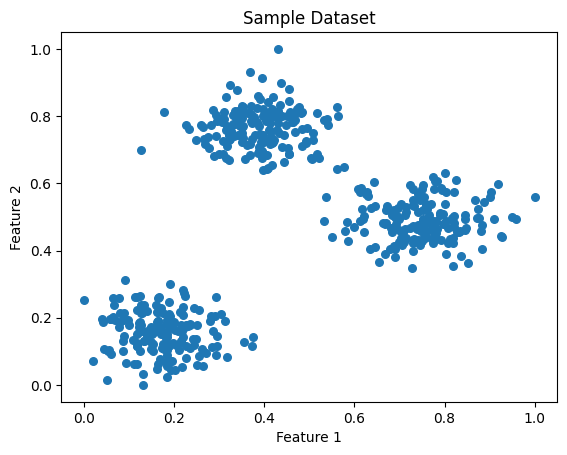

In [44]:
# Generate 500 samples, 3 cluster centers, 2 features (for 2D visualisation)
X, y = make_blobs(n_samples=500, centers=3, cluster_std=1.6,
                  #   c=y, cmap="viridis",
                  n_features=2, random_state=42)

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

# Visualise the dataset
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=30)
plt.title("Sample Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [45]:
X.describe()

,0,1
count,500.000000,500.000000
mean,0.437284,0.470313
std,0.250494,0.255426
min,0.000000,0.000000
25%,0.217315,0.203571
50%,0.394213,0.484234
75%,0.693504,0.722237
max,1.000000,1.000000
